In [1]:
# If this is the first time running the script, you must run the following first:
# pip install ipykernel && python -m ipykernel install --user --name=venv
# pip install wget
# pip install GitPython
# pip install Cython
# pip install tensorflow-io
# pip install pycocotools
# pip install absl-py
# pip install tensorflow
# pip install scipy
# pip install pyyaml
# pip install opencv-python
# pip install pyqt5
import os
import git

In [19]:
TRY = 3

LABEL_MAP_NAME = 'label_map.pbtxt'
WORK_SPACE_PATH = os.path.join('workspace','models',f'model_{TRY}')

paths = {
    'PROTOC_PATH': os.path.join('requirements', 'Protoc' ),
    'APIMODEL_PATH': os.path.join('requirements', 'api'),
    'IMAGE_PATH': os.path.join('workspace','images',f'try_{TRY}')
}

files ={
    'LABEL_MAP': os.path.join(WORK_SPACE_PATH, LABEL_MAP_NAME),
    'PIPELINE_CONFIG': os.path.join(WORK_SPACE_PATH,'pipeline.config'),
    'CHECKPOINT1': os.path.join('workspace','models','model_1','fine_tuned_model','checkpoint','ckpt-0'),
    'CHECKPOINT': os.path.join(WORK_SPACE_PATH,'checkpoint','ckpt-0')
}

In [3]:
for path in paths.values():
    if not os.path.exists(path):
        os.makedirs(path)

In [4]:
if not os.path.exists(os.path.join(paths['APIMODEL_PATH'], 'research', 'object_detection')):
    git.Repo.clone_from( 'https://github.com/tensorflow/models', paths['APIMODEL_PATH'])

## Installing tensorflow object detection

In [6]:
import wget
import shutil
import zipfile
print(os.getcwd())
if not os.path.exists(os.path.join(paths['PROTOC_PATH'],'protoc-3.15.6-win64.zip')):
    url="https://github.com/protocolbuffers/protobuf/releases/download/v3.15.6/protoc-3.15.6-win64.zip"
    wget.download(url)
    shutil.move('protoc-3.15.6-win64.zip', paths['PROTOC_PATH'])
    with zipfile.ZipFile(os.path.join(paths['PROTOC_PATH'],'protoc-3.15.6-win64.zip'), 'r') as zip_ref:
        zip_ref.extractall(paths['PROTOC_PATH'])
# os.environ['PATH'] += os.pathsep + os.path.abspath(os.path.join(paths['PROTOC_PATH'], 'bin'))
# print(os.environ['PATH'])

g:\Mi unidad\Portafolio\Object_detection


In [14]:
# Execute this commands preferibly in the command prompt
!export PATH="$PATH:$PWD/requirements/Protoc/bin"
!cd requirements/api/research && protoc object_detection/protos/*.proto --python_out=. && cp object_detection/packages/tf2/setup.py setup.py && python setup.py build && python setup.py install
!cd ..; cd ..;cd ..;cd requirements/api/research/slim && pip install -e .
!python requirements/api/research/object_detection/builders/model_builder_tf2_test.py

## Detecting images

In [3]:
import cv2 

In [4]:

import numpy as np
import tensorflow as tf
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.builders import model_builder
from object_detection.utils import config_util

In [5]:
#Load a pipeline config
configs = config_util.get_configs_from_pipeline_file(files['PIPELINE_CONFIG'])

#build a detection model
detection_model = model_builder.build(model_config=configs['model'], is_training=False)

In [6]:
category_index = label_map_util.create_category_index_from_labelmap(files['LABEL_MAP'])

In [25]:
# Restore a checkpoint
ckpt = tf.compat.v2.train.Checkpoint(model=detection_model)
ckpt.restore(os.path.join(files['CHECKPOINT1'])).expect_partial()

In [8]:
@tf.function
def detect_fn(image):
    image, shapes = detection_model.preprocess(image)
    prediction_dict = detection_model.predict(image, shapes)
    detections = detection_model.postprocess(prediction_dict, shapes)
    return detections

In [24]:
IMAGE_PATH = os.path.join(paths['IMAGE_PATH'],'train','indicearriba.0d59e0d0-94bb-11ec-852d-76dfbf68ea0d.jpg')


In [ ]:
os.listdir(os.path.join(paths['IMAGE_PATH'],'train'))

In [9]:
from matplotlib import pyplot as plt
%matplotlib inline

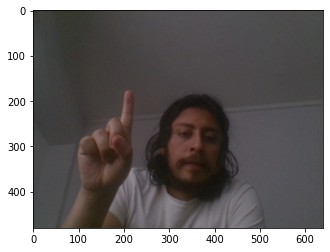

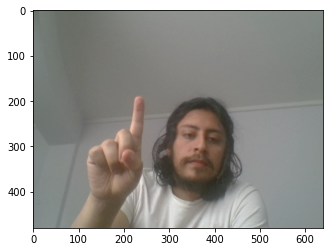

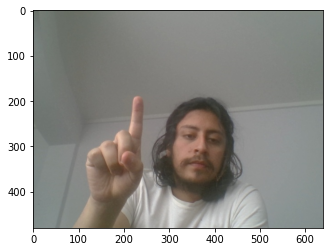

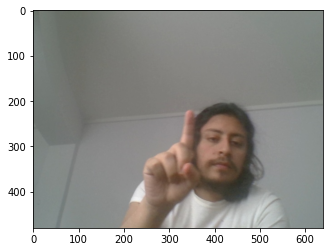

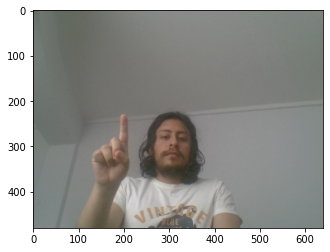

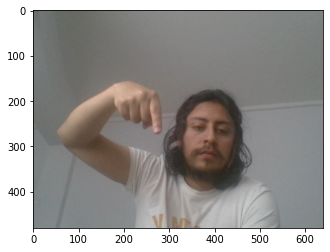

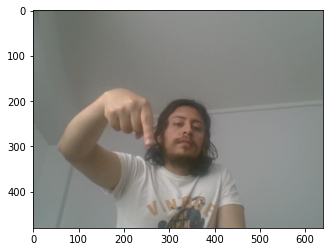

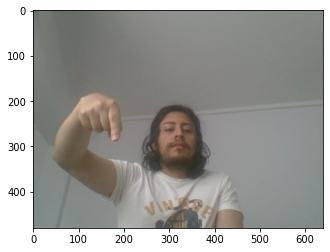

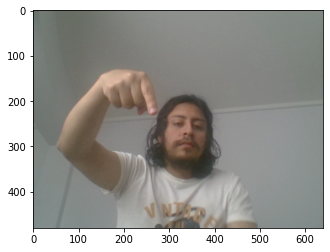

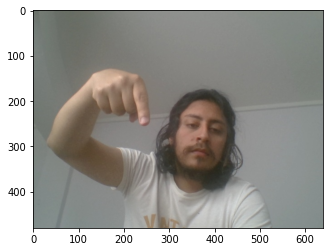

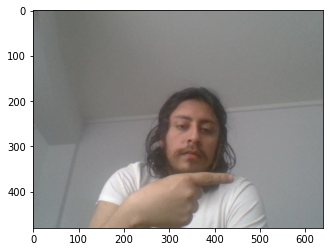

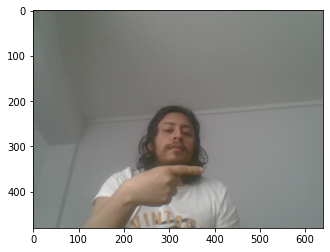

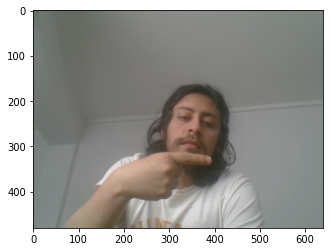

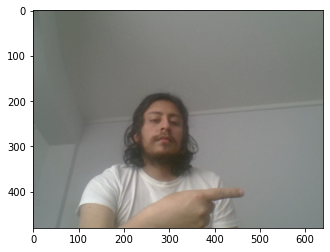

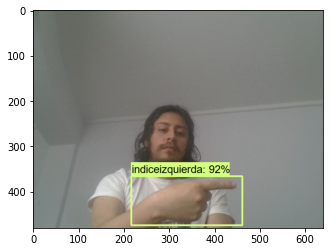

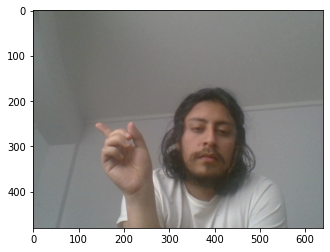

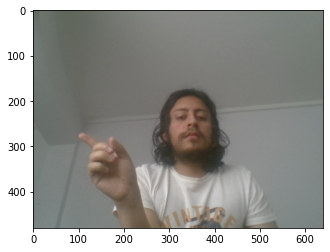

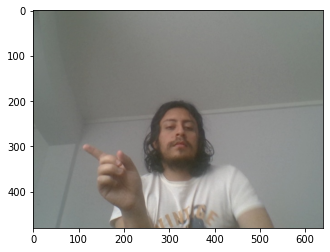

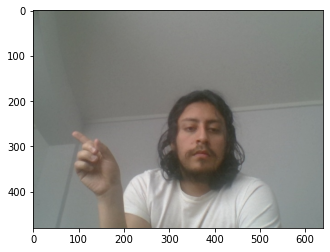

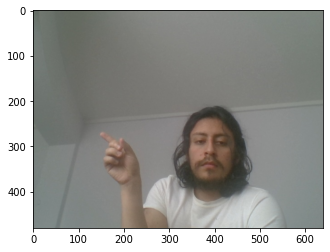

In [26]:
type_image='test'
for image in os.listdir(os.path.join(paths['IMAGE_PATH'],type_image)):
    image_path = os.path.join(paths['IMAGE_PATH'],type_image, image)
    img = cv2.imread(image_path)
    image_np = np.array(img)

    input_tensor = tf.convert_to_tensor(np.expand_dims(image_np, 0), dtype=tf.float32)
    detections = detect_fn(input_tensor)

    num_detections = int(detections.pop('num_detections'))
    detections = {key: value[0, :num_detections].numpy()
                for key, value in detections.items()}
    detections['num_detections'] = num_detections

    # detection_classes should be ints.
    detections['detection_classes'] = detections['detection_classes'].astype(np.int64)

    label_id_offset = 1
    image_np_with_detections = image_np.copy()

    viz_utils.visualize_boxes_and_labels_on_image_array(
                image_np_with_detections,
                detections['detection_boxes'],
                detections['detection_classes']+label_id_offset,
                detections['detection_scores'],
                category_index,
                use_normalized_coordinates=True,
                max_boxes_to_draw=5,
                min_score_thresh=.8,
                agnostic_mode=False)

    plt.imshow(cv2.cvtColor(image_np_with_detections, cv2.COLOR_BGR2RGB))
    plt.show()

In [ ]:
np.array(img)

In [22]:
cap = cv2.VideoCapture(0)
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

while cap.isOpened(): 
    ret, frame = cap.read()
    image_np = np.array(frame)
    
    input_tensor = tf.convert_to_tensor(np.expand_dims(image_np, 0), dtype=tf.float32)
    detections = detect_fn(input_tensor)
    
    num_detections = int(detections.pop('num_detections'))
    detections = {key: value[0, :num_detections].numpy()
                  for key, value in detections.items()}
    detections['num_detections'] = num_detections

    # detection_classes should be ints.
    detections['detection_classes'] = detections['detection_classes'].astype(np.int64)

    label_id_offset = 1
    image_np_with_detections = image_np.copy()

    viz_utils.visualize_boxes_and_labels_on_image_array(
                image_np_with_detections,
                detections['detection_boxes'],
                detections['detection_classes']+label_id_offset,
                detections['detection_scores'],
                category_index,
                use_normalized_coordinates=True,
                max_boxes_to_draw=5,
                min_score_thresh=.6,
                agnostic_mode=False)

    cv2.imshow('object detection',  cv2.resize(image_np_with_detections, (800, 600)))
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        cap.release()
        cv2.destroyAllWindows()
        break